# ARIMA

## Data Engineering and Visualization

In [1]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
csv_files = glob.glob('*.csv')
csv_files

['USDEUR=X.csv',
 'EURGBP=X.csv',
 'USDCHF=X.csv',
 'GBPCHF=X.csv',
 'USDGBP=X.csv']

In [3]:
#personal preference
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv','EURGBP=X.csv', 'GBPCHF=X.csv']

In [4]:
df_temp=pd.read_csv('USDEUR=X.csv')
df_temp

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-04,0.74109,0.743770,0.739640,0.74107,0.74107,0.0
1,2013-11-05,0.73986,0.743510,0.739430,0.73981,0.73981,0.0
2,2013-11-06,0.74223,0.742460,0.738171,0.74222,0.74222,0.0
3,2013-11-07,0.73977,0.751552,0.739044,0.73975,0.73975,0.0
4,2013-11-08,0.74577,0.750677,0.744253,0.74576,0.74576,0.0
...,...,...,...,...,...,...,...
2604,2023-10-27,0.94657,0.949100,0.943600,0.94657,0.94657,0.0
2605,2023-10-30,0.94675,0.948010,0.941088,0.94675,0.94675,0.0
2606,2023-10-31,0.94206,0.946290,0.937290,0.94206,0.94206,0.0
2607,2023-11-01,0.94526,0.950310,0.945110,0.94526,0.94526,0.0


In [5]:
df_train=[]
df_test=[]
for path in filepath:
    df_temp=pd.read_csv(path)
    #Since we need to make more profits, we only need the highest rate in a day.
    #We no longer need date, because we can use index.
    df_temp=df_temp[['High']]
    df_temp.columns=['rate']
    df_train.append(df_temp[:-5])
    df_test.append(df_temp[-5:])

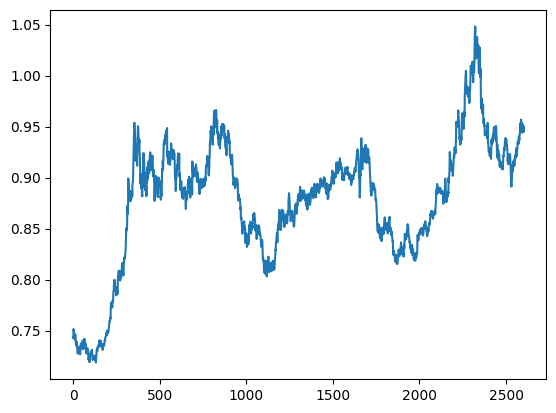

In [6]:
plt.plot(np.array(df_train[0].index),np.array(df_train[0])[:])

In [7]:
def test_stationarity(timeseries):
    # execute Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    print(f'p-value={dftest[1]}')

In [8]:
# First order difference is enough to make timeseries stationary, beacuase p-value<0.05. 
for i in range(5):
    print(f"{i}:")
    test_stationarity(df_train[i]['rate'])
    #test first-order difference
    test_stationarity(df_train[i]['rate'].diff().dropna())

0:


MissingDataError: exog contains inf or nans

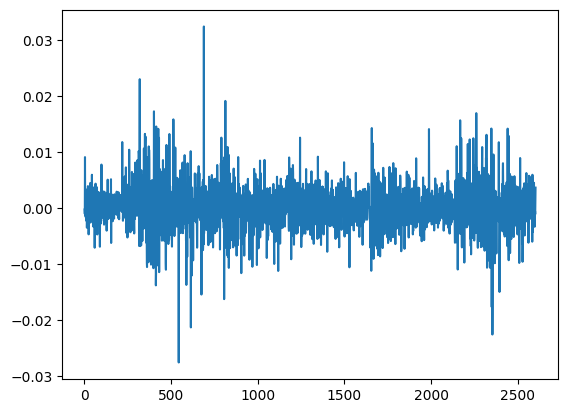

In [9]:
# By utilizing first order difference, we have made the timeseries stationary
plt.plot(df_train[0].diff().dropna())

/opt/homebrew/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


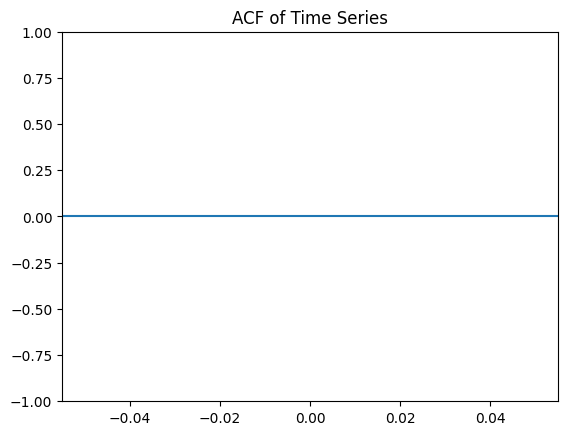

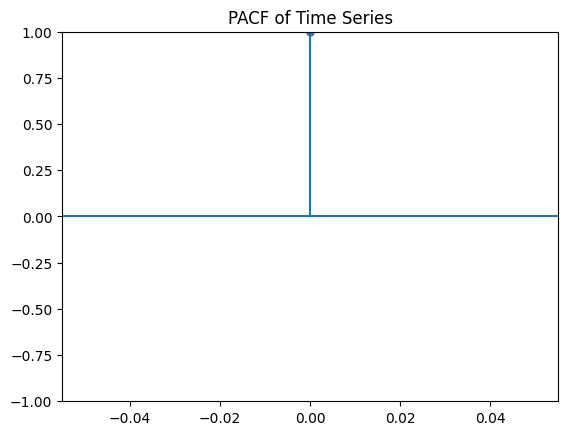

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot ACF figure
plot_acf(df_train[0], lags=20)
plt.title('ACF of Time Series')
plt.show()

# plot PACF figure
plot_pacf(df_train[0], lags=20)
plt.title('PACF of Time Series')
plt.show()

# Train Prophet Model

In [11]:
!pip3 install prophet 
!pip3 install --upgrade plotly
!pip3 install pandas_market_calendars
!pip3 install --upgrade pandas
from prophet import Prophet
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid


## As prophet needs datetime and numeric value as input, I will re-process the input data here

In [12]:
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv','EURGBP=X.csv', 'GBPCHF=X.csv']
df_train_prophet=[]
df_test_prophet=[]
df_all_prophet = []
for path in filepath:
    df_temp=pd.read_csv(path)[["Date", "High"]] # keep both Date and High
    df_temp = df_temp.rename(columns={"Date": "ds", "High": "y"})
    df_train_prophet.append(df_temp[:-5])
    df_test_prophet.append(df_temp[-5:])
    df_all_prophet.append(df_temp)

In [13]:
df_train_prophet[0]

,ds,y
0,2013-11-04,0.743770
1,2013-11-05,0.743510
2,2013-11-06,0.742460
3,2013-11-07,0.751552
4,2013-11-08,0.750677
...,...,...
2599,2023-10-20,0.946450
2600,2023-10-23,0.945910
2601,2023-10-24,0.944800
2602,2023-10-25,0.946360


In [14]:
df_test_prophet[0]

,ds,y
2604,2023-10-27,0.94910
2605,2023-10-30,0.94801
2606,2023-10-31,0.94629
2607,2023-11-01,0.95031
2608,2023-11-02,0.94600


In [15]:
prophet_models = []

for curve_data in df_train_prophet:
    model = Prophet()
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_models.append((model, forecast))

17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing
17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1] done processing
17:51:17 - cmdstanpy - INFO - Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1] done processing
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
prophet_models[0][1]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-10-27,0.959821,0.932178,0.990842,0.959821,0.959821,0.002765,0.002765,0.002765,-0.000157,-0.000157,-0.000157,0.002923,0.002923,0.002923,0.0,0.0,0.0,0.962586
1,2023-10-30,0.960028,0.937190,0.990388,0.960028,0.960028,0.003218,0.003218,0.003218,-0.000766,-0.000766,-0.000766,0.003984,0.003984,0.003984,0.0,0.0,0.0,0.963247
2,2023-10-31,0.960098,0.934971,0.991636,0.960098,0.960098,0.003817,0.003817,0.003817,-0.000594,-0.000594,-0.000594,0.004411,0.004411,0.004411,0.0,0.0,0.0,0.963915
3,2023-11-01,0.960167,0.936141,0.990693,0.960167,0.960167,0.004253,0.004253,0.004253,-0.000611,-0.000611,-0.000611,0.004864,0.004864,0.004864,0.0,0.0,0.0,0.964420
4,2023-11-02,0.960236,0.939275,0.993497,0.960236,0.960236,0.005060,0.005060,0.005060,-0.000276,-0.000276,-0.000276,0.005336,0.005336,0.005336,0.0,0.0,0.0,0.965296


# Calculate Errors For Prediction

In [17]:
errors = []
def calculate_mse(truth, prediction):
    """ 
    truth, prediction: 5x5 array, predictions for the next 5 trading days for 5 curves 
    """
    errors = [np.mean(np.square(truth[i] - prediction)) for i in range(len(truth))]
    return errors, np.sum(errors)

calculate_mse([df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))], [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))])

([0.0065798202666835295,
  0.019697633959891447,
  0.00761180895192523,
  0.011021959907979802,
  0.03261570163792628],
 0.07752692472440628)

## Plot the ground truth and prediction

In [18]:
def draw_pred_truth(truth, pred):
    fig, axes = plt.subplots(1, len(truth), figsize=(30, 10))
    for i in range(5):
        ax = axes[i]
        ax.plot(truth[i], label='Truth')
        ax.plot(pred[i], label='Pred')
        ax.set_title(f'Plot {i + 1}')
        ax.legend()
        ax.grid()
    plt.tight_layout()
    plt.show()

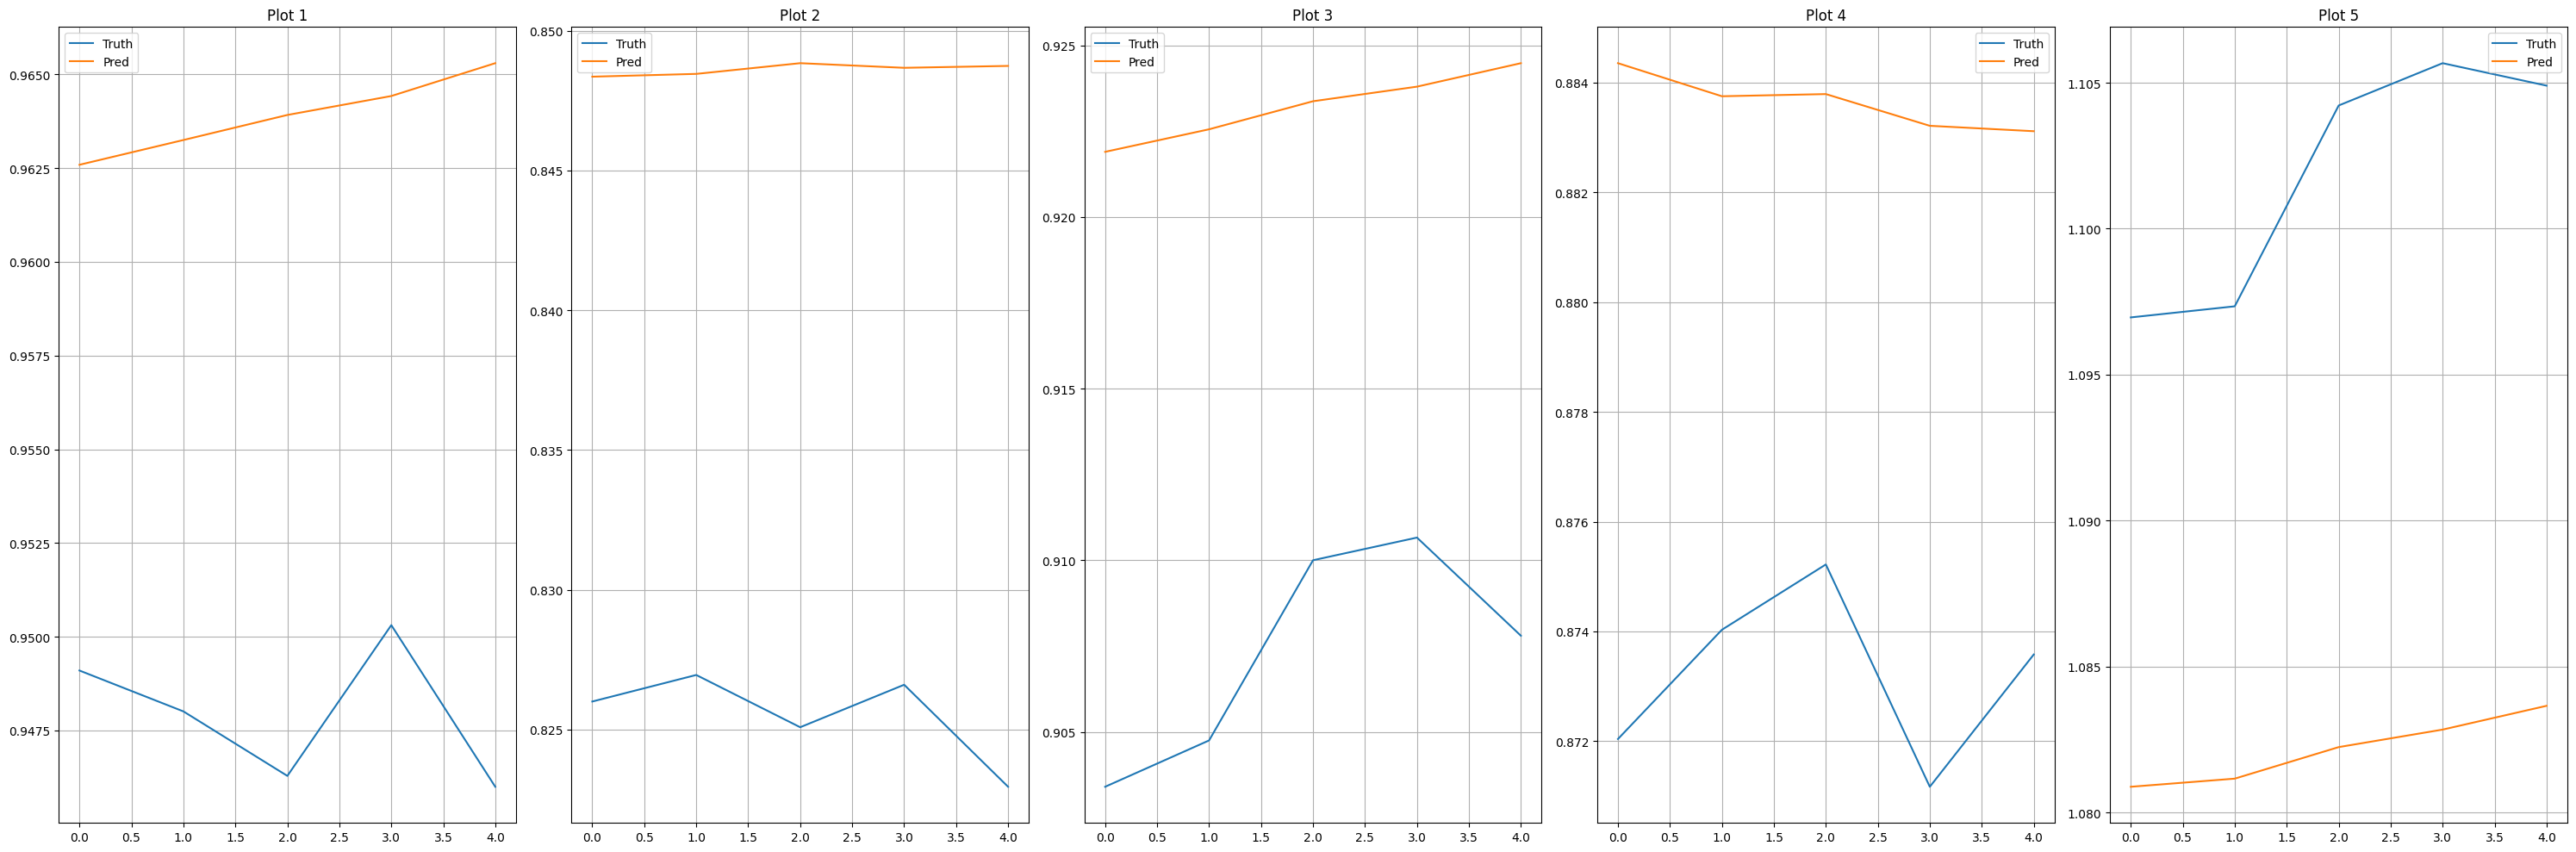

In [19]:
truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
draw_pred_truth(truth_prophet, pred_prophet)

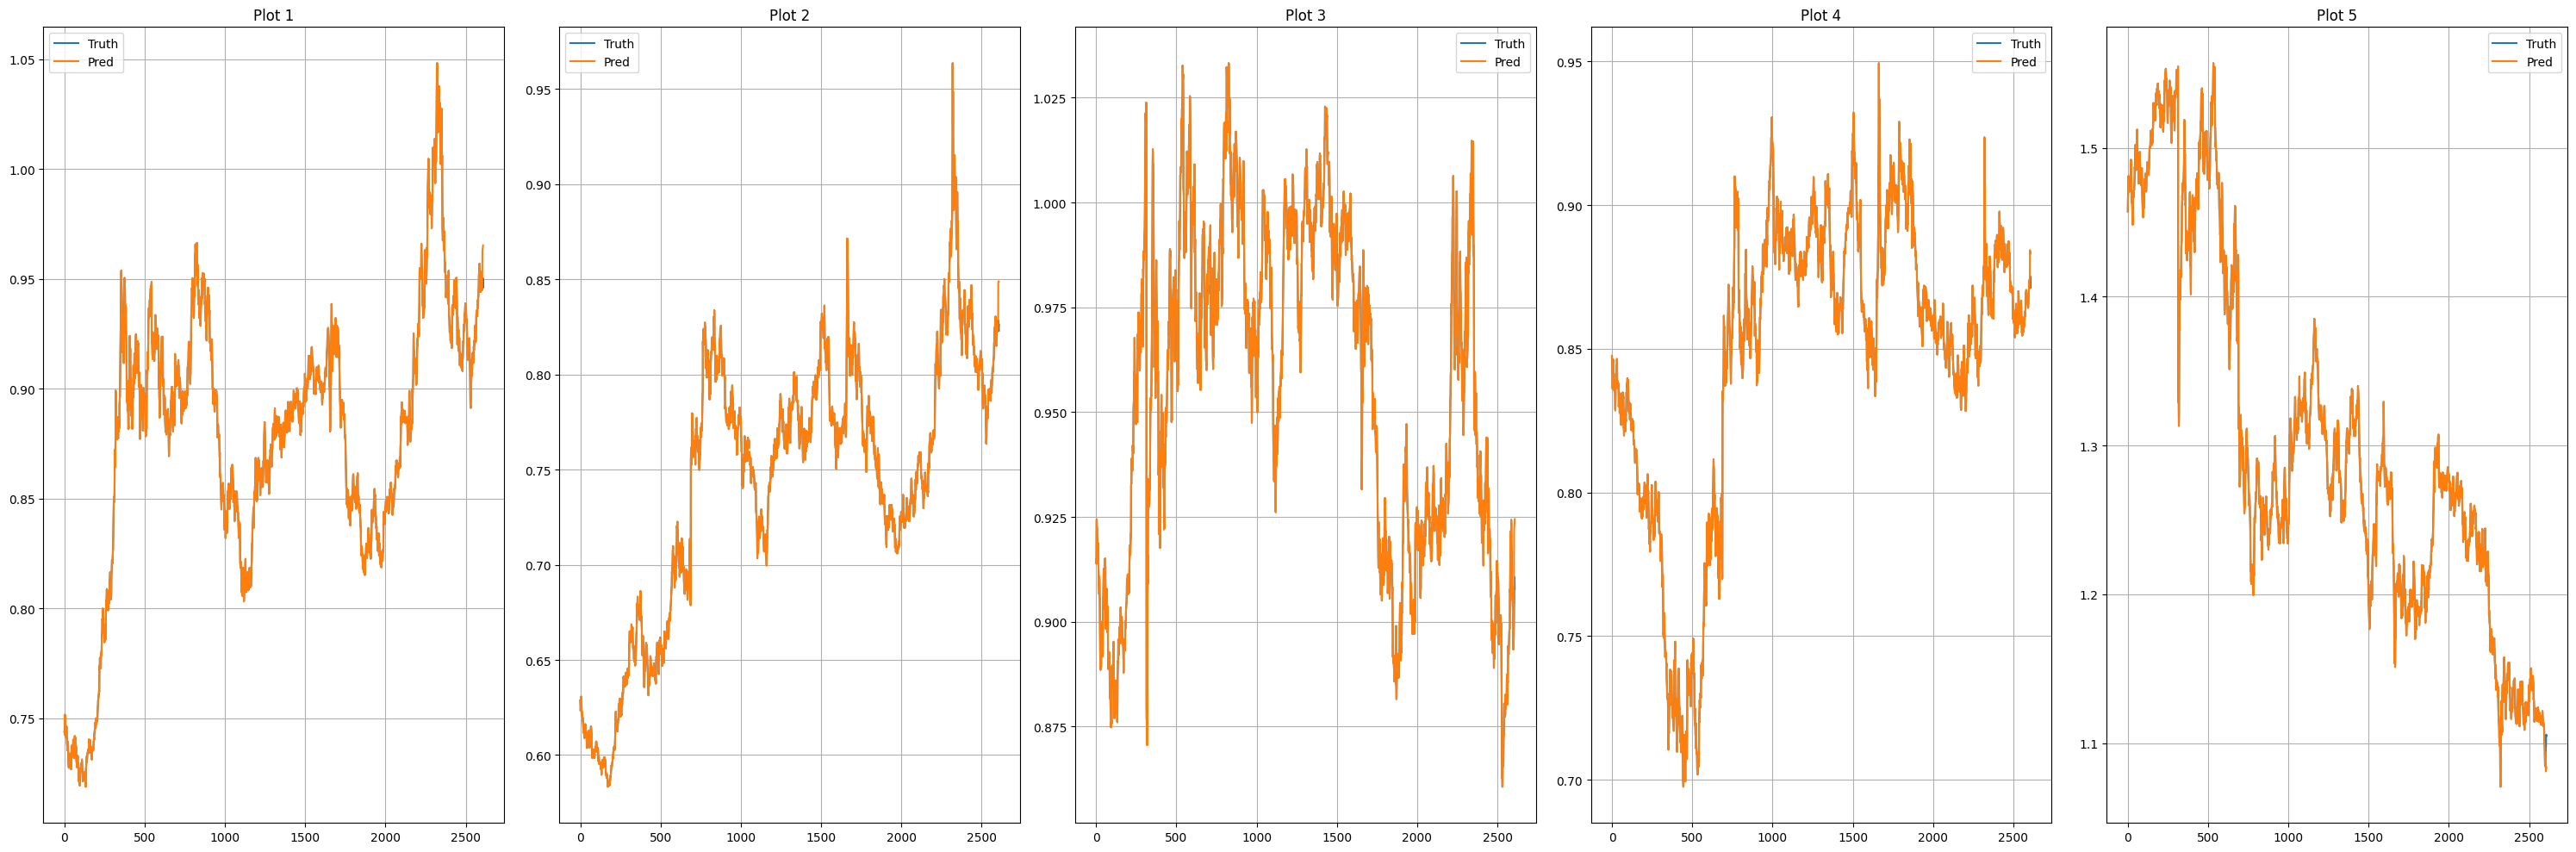

In [20]:
train_pred_prophet = [np.concatenate((df_train_prophet[i]['y'].to_numpy(), prophet_models[i][1]['yhat'].to_numpy()), axis=0) for i in range(len(df_train_prophet))]
# print(len(train_pred_prophet))
draw_pred_truth([df_all_prophet[i]['y'].to_numpy() for i in range(len(df_all_prophet))], train_pred_prophet)


## Hyper parameter tunning to find the best model

In [ ]:
# Define a range of hyperparameter values to search
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1], # default 0.05
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
}
best_mse = float('inf')
best_params = {}
ground_truth = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]

# Iterate through the parameter grid and find the best hyperparameters
for params in ParameterGrid(param_grid):
    print(f"params is {params}")
    para_models = []
    for curve_data in df_train_prophet:
        # Create a Prophet model with the current hyperparameters
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale']
        )
        
        # Fit the model on the training data
        model.fit(curve_data)
        
        last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
        # Create a date range for the next 5 trading days, excluding weekends
        future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
        # Create a DataFrame with these dates
        future_df = pd.DataFrame({'ds': future_dates})
        # Make predictions
        forecast = model.predict(future_df)

        para_models.append((model, forecast))
    _, mse = calculate_mse(ground_truth, [para_models[i][1]['yhat'].to_numpy() for i in range(len(para_models))])
    print(f"MSE is {mse}")
    # Check if the current set of hyperparameters results in a better model
    if mse < best_mse:
        best_mse = mse
        best_params = params

print("Best Hyperparameters:")
print(best_params)
print("Best MSE:", best_mse)

17:43:44 - cmdstanpy - INFO - Chain [1] start processing


params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


17:43:44 - cmdstanpy - INFO - Chain [1] done processing
17:43:44 - cmdstanpy - INFO - Chain [1] start processing
17:43:45 - cmdstanpy - INFO - Chain [1] done processing
17:43:45 - cmdstanpy - INFO - Chain [1] start processing
17:43:45 - cmdstanpy - INFO - Chain [1] done processing
17:43:45 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:46 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:46 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07981852440185139
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:46 - cmdstanpy - INFO - Chain [1] start processing
17:43:47 - cmdstanpy - INFO - Chain [1] done processing
17:43:47 - cmdstanpy - INFO - Chain [1] start processing
17:43:47 - cmdstanpy - INFO - Chain [1] done processing
17:43:47 - cmdstanpy - INFO - Chain [1] start processing
17:43:48 - cmdstanpy - INFO - Chain [1] done processing
17:43:48 - cmdstanpy - INFO - Chain [1] start processing
17:43:48 - cmdstanpy - INFO - Chain [1] done processing
17:43:48 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.08003939893412317
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


17:43:48 - cmdstanpy - INFO - Chain [1] done processing
17:43:48 - cmdstanpy - INFO - Chain [1] start processing
17:43:49 - cmdstanpy - INFO - Chain [1] done processing
17:43:49 - cmdstanpy - INFO - Chain [1] start processing
17:43:49 - cmdstanpy - INFO - Chain [1] done processing
17:43:49 - cmdstanpy - INFO - Chain [1] start processing
17:43:49 - cmdstanpy - INFO - Chain [1] done processing
17:43:50 - cmdstanpy - INFO - Chain [1] start processing
17:43:50 - cmdstanpy - INFO - Chain [1] done processing
17:43:50 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07977526482464714
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


17:43:50 - cmdstanpy - INFO - Chain [1] done processing
17:43:50 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:52 - cmdstanpy - INFO - Chain [1] done processing
17:43:52 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.08000108187893734
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


17:43:52 - cmdstanpy - INFO - Chain [1] done processing
17:43:52 - cmdstanpy - INFO - Chain [1] start processing
17:43:52 - cmdstanpy - INFO - Chain [1] done processing
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07981852440185139
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:55 - cmdstanpy - INFO - Chain [1] done processing
17:43:55 - cmdstanpy - INFO - Chain [1] start processing
17:43:55 - cmdstanpy - INFO - Chain [1] done processing
17:43:55 - cmdstanpy - INFO - Chain [1] start processing
17:43:56 - cmdstanpy - INFO - Chain [1] done processing
17:43:56 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.08003939893412317
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


17:43:56 - cmdstanpy - INFO - Chain [1] done processing
17:43:56 - cmdstanpy - INFO - Chain [1] start processing
17:43:56 - cmdstanpy - INFO - Chain [1] done processing
17:43:56 - cmdstanpy - INFO - Chain [1] start processing
17:43:57 - cmdstanpy - INFO - Chain [1] done processing
17:43:57 - cmdstanpy - INFO - Chain [1] start processing
17:43:57 - cmdstanpy - INFO - Chain [1] done processing
17:43:57 - cmdstanpy - INFO - Chain [1] start processing
17:43:57 - cmdstanpy - INFO - Chain [1] done processing
17:43:57 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07977526482464714
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


17:43:58 - cmdstanpy - INFO - Chain [1] done processing
17:43:58 - cmdstanpy - INFO - Chain [1] start processing
17:43:58 - cmdstanpy - INFO - Chain [1] done processing
17:43:58 - cmdstanpy - INFO - Chain [1] start processing
17:43:59 - cmdstanpy - INFO - Chain [1] done processing
17:43:59 - cmdstanpy - INFO - Chain [1] start processing
17:43:59 - cmdstanpy - INFO - Chain [1] done processing
17:43:59 - cmdstanpy - INFO - Chain [1] start processing
17:43:59 - cmdstanpy - INFO - Chain [1] done processing
17:43:59 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.08000108187893734
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


17:44:00 - cmdstanpy - INFO - Chain [1] done processing
17:44:00 - cmdstanpy - INFO - Chain [1] start processing
17:44:00 - cmdstanpy - INFO - Chain [1] done processing
17:44:00 - cmdstanpy - INFO - Chain [1] start processing
17:44:00 - cmdstanpy - INFO - Chain [1] done processing
17:44:00 - cmdstanpy - INFO - Chain [1] start processing
17:44:01 - cmdstanpy - INFO - Chain [1] done processing
17:44:01 - cmdstanpy - INFO - Chain [1] start processing
17:44:01 - cmdstanpy - INFO - Chain [1] done processing
17:44:01 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07981852440185139
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:02 - cmdstanpy - INFO - Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:02 - cmdstanpy - INFO - Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:02 - cmdstanpy - INFO - Chain [1] start processing
17:44:03 - cmdstanpy - INFO - Chain [1] done processing
17:44:03 - cmdstanpy - INFO - Chain [1] start processing
17:44:03 - cmdstanpy - INFO - Chain [1] done processing
17:44:03 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.08003939893412317
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


17:44:03 - cmdstanpy - INFO - Chain [1] done processing
17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:04 - cmdstanpy - INFO - Chain [1] done processing
17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:04 - cmdstanpy - INFO - Chain [1] done processing
17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:05 - cmdstanpy - INFO - Chain [1] done processing
17:44:05 - cmdstanpy - INFO - Chain [1] start processing
17:44:05 - cmdstanpy - INFO - Chain [1] done processing
17:44:05 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07977526482464714
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


17:44:05 - cmdstanpy - INFO - Chain [1] done processing
17:44:05 - cmdstanpy - INFO - Chain [1] start processing
17:44:06 - cmdstanpy - INFO - Chain [1] done processing
17:44:06 - cmdstanpy - INFO - Chain [1] start processing
17:44:06 - cmdstanpy - INFO - Chain [1] done processing
17:44:06 - cmdstanpy - INFO - Chain [1] start processing
17:44:06 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:07 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.08000108187893734
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


17:44:07 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:08 - cmdstanpy - INFO - Chain [1] done processing
17:44:08 - cmdstanpy - INFO - Chain [1] start processing
17:44:08 - cmdstanpy - INFO - Chain [1] done processing
17:44:08 - cmdstanpy - INFO - Chain [1] start processing
17:44:08 - cmdstanpy - INFO - Chain [1] done processing
17:44:08 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07981852440185139
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:10 - cmdstanpy - INFO - Chain [1] done processing
17:44:10 - cmdstanpy - INFO - Chain [1] start processing
17:44:10 - cmdstanpy - INFO - Chain [1] done processing
17:44:10 - cmdstanpy - INFO - Chain [1] start processing
17:44:10 - cmdstanpy - INFO - Chain [1] done processing
17:44:10 - cmdstanpy - INFO - Chain [1] start processing
17:44:11 - cmdstanpy - INFO - Chain [1] done processing
17:44:11 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.08003939893412317
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


17:44:11 - cmdstanpy - INFO - Chain [1] done processing
17:44:11 - cmdstanpy - INFO - Chain [1] start processing
17:44:11 - cmdstanpy - INFO - Chain [1] done processing
17:44:12 - cmdstanpy - INFO - Chain [1] start processing
17:44:12 - cmdstanpy - INFO - Chain [1] done processing
17:44:12 - cmdstanpy - INFO - Chain [1] start processing
17:44:12 - cmdstanpy - INFO - Chain [1] done processing
17:44:12 - cmdstanpy - INFO - Chain [1] start processing
17:44:12 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07977526482464714
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:14 - cmdstanpy - INFO - Chain [1] done processing
17:44:14 - cmdstanpy - INFO - Chain [1] start processing
17:44:14 - cmdstanpy - INFO - Chain [1] done processing
17:44:14 - cmdstanpy - INFO - Chain [1] start processing
17:44:14 - cmdstanpy - INFO - Chain [1] done processing
17:44:14 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.08000108187893734
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


17:44:15 - cmdstanpy - INFO - Chain [1] done processing
17:44:15 - cmdstanpy - INFO - Chain [1] start processing
17:44:15 - cmdstanpy - INFO - Chain [1] done processing
17:44:15 - cmdstanpy - INFO - Chain [1] start processing
17:44:16 - cmdstanpy - INFO - Chain [1] done processing
17:44:16 - cmdstanpy - INFO - Chain [1] start processing
17:44:17 - cmdstanpy - INFO - Chain [1] done processing
17:44:17 - cmdstanpy - INFO - Chain [1] start processing
17:44:18 - cmdstanpy - INFO - Chain [1] done processing
17:44:18 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07754413352390896
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


17:44:18 - cmdstanpy - INFO - Chain [1] done processing
17:44:19 - cmdstanpy - INFO - Chain [1] start processing
17:44:19 - cmdstanpy - INFO - Chain [1] done processing
17:44:19 - cmdstanpy - INFO - Chain [1] start processing
17:44:20 - cmdstanpy - INFO - Chain [1] done processing
17:44:20 - cmdstanpy - INFO - Chain [1] start processing
17:44:20 - cmdstanpy - INFO - Chain [1] done processing
17:44:20 - cmdstanpy - INFO - Chain [1] start processing
17:44:21 - cmdstanpy - INFO - Chain [1] done processing
17:44:21 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07732153857925472
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


17:44:22 - cmdstanpy - INFO - Chain [1] done processing
17:44:22 - cmdstanpy - INFO - Chain [1] start processing
17:44:22 - cmdstanpy - INFO - Chain [1] done processing
17:44:22 - cmdstanpy - INFO - Chain [1] start processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - INFO - Chain [1] start processing
17:44:24 - cmdstanpy - INFO - Chain [1] done processing
17:44:24 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07734311240937361
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07752692472440628
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07754413352390896
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07732153857925472
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing
17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07734311240937361
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07752692472440628
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07754413352390896
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing
17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07732153857925472
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1] done processing
17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07734311240937361
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07752692472440628
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07754413352390896
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:45:00 - cmdstanpy - INFO - Chain [1] done processing
17:45:00 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07732153857925472
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


17:45:02 - cmdstanpy - INFO - Chain [1] done processing
17:45:02 - cmdstanpy - INFO - Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1] done processing
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07734311240937361
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07752692472440628
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


17:45:09 - cmdstanpy - INFO - Chain [1] done processing
17:45:09 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1] done processing
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1] done processing
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing
17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing
17:45:12 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0777961723923043
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


17:45:13 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:15 - cmdstanpy - INFO - Chain [1] done processing
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1] done processing
17:45:16 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07781903880602026
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


17:45:17 - cmdstanpy - INFO - Chain [1] done processing
17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1] done processing
17:45:20 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07775305255536463
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1] done processing
17:45:22 - cmdstanpy - INFO - Chain [1] start processing
17:45:23 - cmdstanpy - INFO - Chain [1] done processing
17:45:23 - cmdstanpy - INFO - Chain [1] start processing
17:45:23 - cmdstanpy - INFO - Chain [1] done processing
17:45:23 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07779591627839838
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


17:45:25 - cmdstanpy - INFO - Chain [1] done processing
17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:26 - cmdstanpy - INFO - Chain [1] done processing
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing
17:45:27 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
17:45:29 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0777961723923043
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


17:45:29 - cmdstanpy - INFO - Chain [1] done processing
17:45:29 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1] done processing
17:45:30 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
17:45:32 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07781903880602026
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


17:45:33 - cmdstanpy - INFO - Chain [1] done processing
17:45:33 - cmdstanpy - INFO - Chain [1] start processing
17:45:34 - cmdstanpy - INFO - Chain [1] done processing
17:45:34 - cmdstanpy - INFO - Chain [1] start processing
17:45:35 - cmdstanpy - INFO - Chain [1] done processing
17:45:35 - cmdstanpy - INFO - Chain [1] start processing
17:45:36 - cmdstanpy - INFO - Chain [1] done processing
17:45:36 - cmdstanpy - INFO - Chain [1] start processing
17:45:36 - cmdstanpy - INFO - Chain [1] done processing
17:45:37 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07775305255536463
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


17:45:37 - cmdstanpy - INFO - Chain [1] done processing
17:45:37 - cmdstanpy - INFO - Chain [1] start processing
17:45:38 - cmdstanpy - INFO - Chain [1] done processing
17:45:38 - cmdstanpy - INFO - Chain [1] start processing
17:45:39 - cmdstanpy - INFO - Chain [1] done processing
17:45:39 - cmdstanpy - INFO - Chain [1] start processing
17:45:40 - cmdstanpy - INFO - Chain [1] done processing
17:45:40 - cmdstanpy - INFO - Chain [1] start processing
17:45:40 - cmdstanpy - INFO - Chain [1] done processing
17:45:41 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07779591627839838
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


17:45:41 - cmdstanpy - INFO - Chain [1] done processing
17:45:41 - cmdstanpy - INFO - Chain [1] start processing
17:45:42 - cmdstanpy - INFO - Chain [1] done processing
17:45:42 - cmdstanpy - INFO - Chain [1] start processing
17:45:43 - cmdstanpy - INFO - Chain [1] done processing
17:45:43 - cmdstanpy - INFO - Chain [1] start processing
17:45:44 - cmdstanpy - INFO - Chain [1] done processing
17:45:44 - cmdstanpy - INFO - Chain [1] start processing
17:45:45 - cmdstanpy - INFO - Chain [1] done processing
17:45:45 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0777961723923043
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


17:45:45 - cmdstanpy - INFO - Chain [1] done processing
17:45:46 - cmdstanpy - INFO - Chain [1] start processing
17:45:46 - cmdstanpy - INFO - Chain [1] done processing
17:45:46 - cmdstanpy - INFO - Chain [1] start processing
17:45:47 - cmdstanpy - INFO - Chain [1] done processing
17:45:47 - cmdstanpy - INFO - Chain [1] start processing
17:45:48 - cmdstanpy - INFO - Chain [1] done processing
17:45:48 - cmdstanpy - INFO - Chain [1] start processing
17:45:48 - cmdstanpy - INFO - Chain [1] done processing
17:45:49 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07781903880602026
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


17:45:49 - cmdstanpy - INFO - Chain [1] done processing
17:45:49 - cmdstanpy - INFO - Chain [1] start processing
17:45:50 - cmdstanpy - INFO - Chain [1] done processing
17:45:50 - cmdstanpy - INFO - Chain [1] start processing
17:45:51 - cmdstanpy - INFO - Chain [1] done processing
17:45:51 - cmdstanpy - INFO - Chain [1] start processing
17:45:52 - cmdstanpy - INFO - Chain [1] done processing
17:45:52 - cmdstanpy - INFO - Chain [1] start processing
17:45:53 - cmdstanpy - INFO - Chain [1] done processing
17:45:53 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07775305255536463
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


17:45:53 - cmdstanpy - INFO - Chain [1] done processing
17:45:54 - cmdstanpy - INFO - Chain [1] start processing
17:45:54 - cmdstanpy - INFO - Chain [1] done processing
17:45:54 - cmdstanpy - INFO - Chain [1] start processing
17:45:55 - cmdstanpy - INFO - Chain [1] done processing
17:45:55 - cmdstanpy - INFO - Chain [1] start processing
17:45:56 - cmdstanpy - INFO - Chain [1] done processing
17:45:56 - cmdstanpy - INFO - Chain [1] start processing
17:45:57 - cmdstanpy - INFO - Chain [1] done processing
17:45:57 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07779591627839838
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


17:45:58 - cmdstanpy - INFO - Chain [1] done processing
17:45:58 - cmdstanpy - INFO - Chain [1] start processing
17:45:58 - cmdstanpy - INFO - Chain [1] done processing
17:45:59 - cmdstanpy - INFO - Chain [1] start processing
17:45:59 - cmdstanpy - INFO - Chain [1] done processing
17:45:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:00 - cmdstanpy - INFO - Chain [1] done processing
17:46:00 - cmdstanpy - INFO - Chain [1] start processing
17:46:01 - cmdstanpy - INFO - Chain [1] done processing
17:46:01 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0777961723923043
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


17:46:02 - cmdstanpy - INFO - Chain [1] done processing
17:46:02 - cmdstanpy - INFO - Chain [1] start processing
17:46:02 - cmdstanpy - INFO - Chain [1] done processing
17:46:02 - cmdstanpy - INFO - Chain [1] start processing
17:46:03 - cmdstanpy - INFO - Chain [1] done processing
17:46:03 - cmdstanpy - INFO - Chain [1] start processing
17:46:04 - cmdstanpy - INFO - Chain [1] done processing
17:46:04 - cmdstanpy - INFO - Chain [1] start processing
17:46:05 - cmdstanpy - INFO - Chain [1] done processing
17:46:05 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07781903880602026
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


17:46:05 - cmdstanpy - INFO - Chain [1] done processing
17:46:06 - cmdstanpy - INFO - Chain [1] start processing
17:46:06 - cmdstanpy - INFO - Chain [1] done processing
17:46:06 - cmdstanpy - INFO - Chain [1] start processing
17:46:07 - cmdstanpy - INFO - Chain [1] done processing
17:46:07 - cmdstanpy - INFO - Chain [1] start processing
17:46:08 - cmdstanpy - INFO - Chain [1] done processing
17:46:08 - cmdstanpy - INFO - Chain [1] start processing
17:46:09 - cmdstanpy - INFO - Chain [1] done processing
17:46:09 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.07775305255536463
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


17:46:10 - cmdstanpy - INFO - Chain [1] done processing
17:46:10 - cmdstanpy - INFO - Chain [1] start processing
17:46:11 - cmdstanpy - INFO - Chain [1] done processing
17:46:11 - cmdstanpy - INFO - Chain [1] start processing
17:46:11 - cmdstanpy - INFO - Chain [1] done processing
17:46:11 - cmdstanpy - INFO - Chain [1] start processing
17:46:12 - cmdstanpy - INFO - Chain [1] done processing
17:46:12 - cmdstanpy - INFO - Chain [1] start processing
17:46:13 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.07779591627839838
Best Hyperparameters:
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
Best MSE: 0.07732153857925472


In [ ]:
# Best Hyperparameters:
# {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
# Best MSE: 0.07732153857925472


## Now predict using the best model 

17:51:57 - cmdstanpy - INFO - Chain [1] start processing
17:51:57 - cmdstanpy - INFO - Chain [1] done processing
17:51:57 - cmdstanpy - INFO - Chain [1] start processing
17:51:58 - cmdstanpy - INFO - Chain [1] done processing
17:51:58 - cmdstanpy - INFO - Chain [1] start processing
17:51:58 - cmdstanpy - INFO - Chain [1] done processing
17:51:59 - cmdstanpy - INFO - Chain [1] start processing
17:51:59 - cmdstanpy - INFO - Chain [1] done processing
17:51:59 - cmdstanpy - INFO - Chain [1] start processing
17:52:00 - cmdstanpy - INFO - Chain [1] done processing


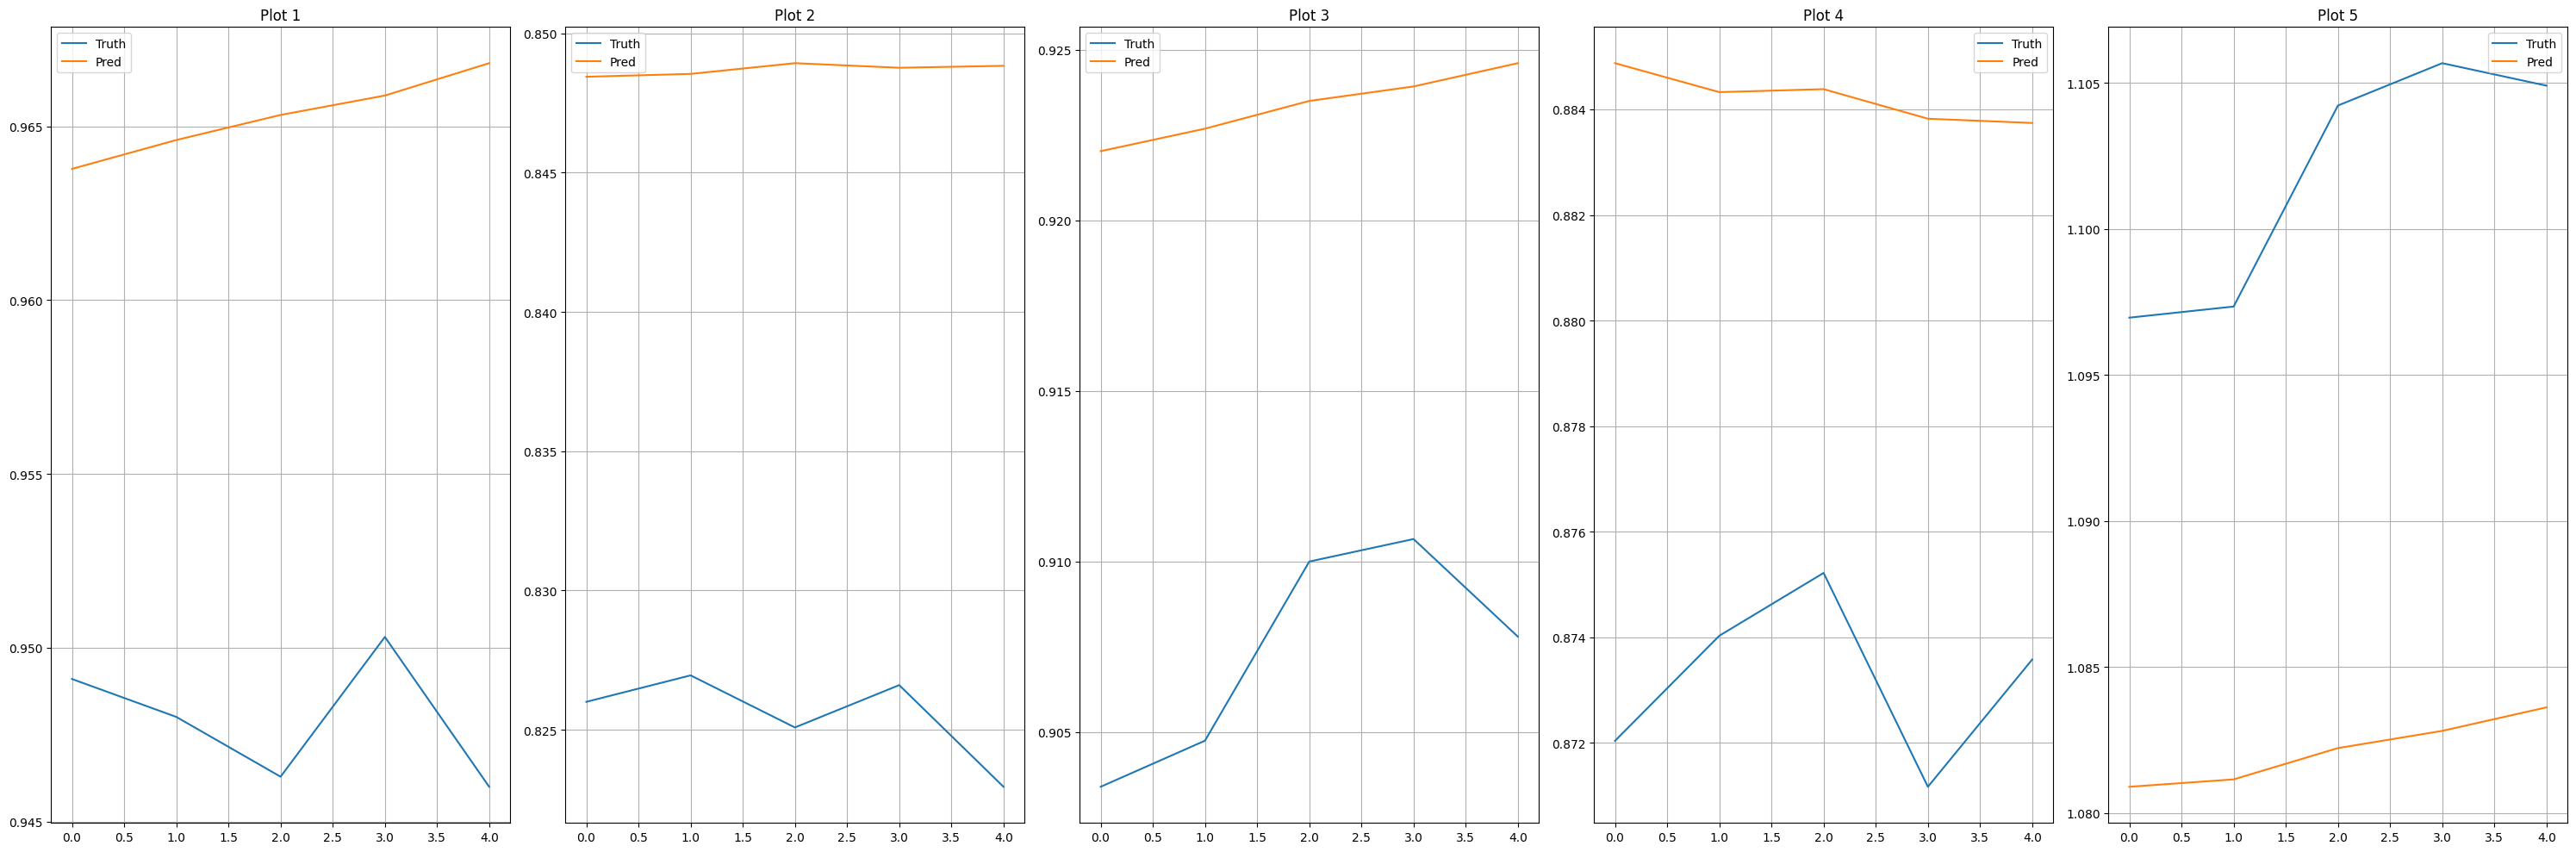

In [21]:
prophet_models = []

for curve_data in df_train_prophet:
    model = Prophet(
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=0.01,
        holidays_prior_scale=0.1
    )
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_models.append((model, forecast))

truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
draw_pred_truth(truth_prophet, pred_prophet)

## Train ARIMA Model

In [ ]:
#split train_dataset into train_dataset and validation_dataset, we set validation_dataset size to be 5, which conforms to test_dataset size
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

In [ ]:
print(train.shape,val.shape)

(252,) (5,)


In [ ]:
# train ARIMA model
from statsmodels.tsa.arima.model import ARIMA

#Since we have already applied difference on data, we set d=0 here.
p,d,q=1,2,1
model = ARIMA(train, order=(p, d, q))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 999.021
Date:                Thu, 02 Nov 2023   AIC                          -1992.042
Time:                        13:20:03   BIC                          -1981.478
Sample:                             0   HQIC                         -1987.790
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0016      0.056      0.028      0.978      -0.109       0.112
ma.L1         -0.9332      0.036    -26.099      0.000      -1.003      -0.863
sigma2      1.961e-05   1.23e-06     16.003      0.0

In [ ]:
train

array([1.01398 , 1.01342 , 1.02762 , 1.0258  , 1.00812 , 1.0024  ,
       0.99875 , 1.00626 , 0.98365 , 0.97337 , 0.96957 , 0.96745 ,
       0.96998 , 0.96824 , 0.9778  , 0.97624 , 0.97105 , 0.96305 ,
       0.96561 , 0.96689 , 0.96848 , 0.9716  , 0.96173 , 0.95839 ,
       0.95307 , 0.95447 , 0.95751 , 0.95314 , 0.95057 , 0.95174 ,
       0.94973 , 0.94161 , 0.94274 , 0.94345 , 0.94543 , 0.94512 ,
       0.94366 , 0.94482 , 0.94447 , 0.9426  , 0.94229 , 0.94216 ,
       0.9423  , 0.93992 , 0.93868 , 0.95043 , 0.94823 , 0.95097 ,
       0.95372 , 0.93872 , 0.93343 , 0.93224 , 0.93127 , 0.92759 ,
       0.9257  , 0.92704 , 0.92876 , 0.92739 , 0.92553 , 0.92187 ,
       0.92257 , 0.92097 , 0.92152 , 0.92261 , 0.92127 , 0.92557 ,
       0.92141 , 0.91847 , 0.92498 , 0.93298 , 0.93725 , 0.93311 ,
       0.93357 , 0.93727 , 0.93833 , 0.93371 , 0.93756 , 0.93846 ,
       0.94217 , 0.93707 , 0.93942 , 0.9417  , 0.945   , 0.94897 ,
       0.94935 , 0.94497 , 0.94646 , 0.94487 , 0.94417 , 0.941

In [ ]:
# prediction
train_predictions = result.predict(start=1, end=train.shape[0])
print(train_predictions)

val_predictions = result.get_forecast(len(val)).predicted_mean
print(val_predictions)

[1.52097    1.01286    1.03446923 1.02971438 1.00652539 0.99997623
 0.9961164  1.00518073 0.97961334 0.96858634 0.9649078  0.96305852
 0.96628302 0.96472075 0.97547703 0.97396565 0.96852568 0.96007583
 0.96309127 0.96466385 0.96654461 0.97004513 0.95954182 0.95612828
 0.95058508 0.95227253 0.95568526 0.95112504 0.94851918 0.94991833
 0.94789034 0.9393293  0.94070729 0.94160374 0.94384605 0.94361891
 0.94215988 0.94350382 0.94321665 0.9413027  0.94106161 0.94100575
 0.94123313 0.93876102 0.93751738 0.95015344 0.94780262 0.95076251
 0.95371051 0.93767942 0.93212042 0.93094486 0.92999695 0.92615181
 0.92423438 0.92576707 0.92768779 0.92629302 0.92438123 0.92055048
 0.92139237 0.91976051 0.92043155 0.92166806 0.92029762 0.92495904
 0.92054842 0.91747136 0.9244983  0.93306778 0.93761156 0.93315733
 0.93365216 0.93759917 0.93870388 0.93374103 0.93785971 0.93879521
 0.94273529 0.93724261 0.93974993 0.94216021 0.9456517  0.94984464
 0.95018591 0.94544966 0.94701645 0.94527808 0.94450539 0.9414

In [ ]:
val

array([0.94977, 0.94645, 0.94591, 0.9448 , 0.94636])

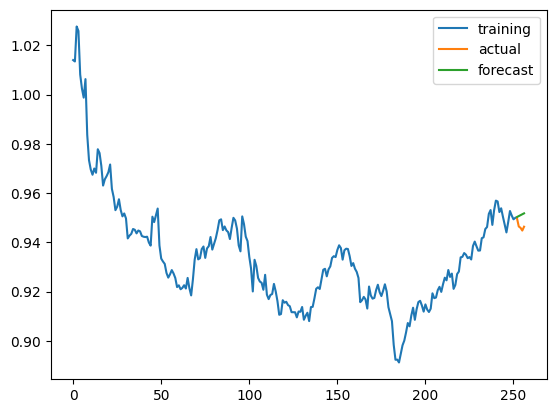

In [ ]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(train_predictions,train)
val_mse = mean_squared_error(val_predictions, val)

print("train_MSE:", train_mse)
print("val_MSE:", val_mse)

train_MSE: 0.0010216117375709882
val_MSE: 2.3513116994187704e-05


## Fine-tuning

In [ ]:
#gird search
min_val_mse=1e9
optimal_p=1
optimal_d=1
optimal_q=1
for p in range(1,6):
    for d in range(1,3):
        for q in range(1,6):
            model = ARIMA(train, order=(p, d, q))
            result = model.fit()
            train_predictions = result.predict(start=1, end=train.shape[0])
            val_predictions = result.get_forecast(len(val)).predicted_mean
            train_mse = mean_squared_error(train_predictions,train)
            val_mse = mean_squared_error(val_predictions, val)
            if (val_mse<min_val_mse):
                min_val_mse=val_mse
                optimal_p=p
                optimal_q=q
                optimal_d=d
            print(f"p={p},d={d},q={q}:")
            print("train_MSE:", train_mse)
            print("val_MSE:", val_mse)
            print("-------------------------------------------------------------")

p=1,d=1,q=1:
train_MSE: 8.145408116927833e-08
val_MSE: 1.3705245389727252e-05
-------------------------------------------------------------
p=1,d=1,q=2:
train_MSE: 6.896297345830628e-08
val_MSE: 1.3732187941729022e-05
-------------------------------------------------------------
p=1,d=1,q=3:
train_MSE: 2.2337896798333838e-07
val_MSE: 1.3865944538362441e-05
-------------------------------------------------------------
p=1,d=1,q=4:
train_MSE: 2.6119589484092575e-07
val_MSE: 1.5244421545107135e-05
-------------------------------------------------------------
p=1,d=1,q=5:
train_MSE: 7.394515106738006e-07
val_MSE: 2.4023153104262467e-05
-------------------------------------------------------------
p=1,d=2,q=1:
train_MSE: 0.0010216117375709882
val_MSE: 2.3513116994187704e-05
-------------------------------------------------------------
p=1,d=2,q=2:
train_MSE: 0.001022133504207569
val_MSE: 1.9073653262106937e-05
-------------------------------------------------------------
p=1,d=2,q=3:
train_

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=1,d=2,q=4:
train_MSE: 0.0010219851602709786
val_MSE: 1.8735317623457784e-05
-------------------------------------------------------------
p=1,d=2,q=5:
train_MSE: 0.0010220355168042228
val_MSE: 2.1886148248304264e-05
-------------------------------------------------------------
p=2,d=1,q=1:
train_MSE: 2.7118410937698715e-07
val_MSE: 1.4408417289394884e-05
-------------------------------------------------------------
p=2,d=1,q=2:
train_MSE: 2.3501912845742295e-07
val_MSE: 1.4163934757678001e-05
-------------------------------------------------------------
p=2,d=1,q=3:
train_MSE: 3.229005526498587e-07
val_MSE: 1.3977244795092898e-05
-------------------------------------------------------------
p=2,d=1,q=4:
train_MSE: 2.8327230107596017e-07
val_MSE: 1.458038227948638e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2,d=1,q=5:
train_MSE: 8.87583233963981e-07
val_MSE: 2.7186252151084816e-05
-------------------------------------------------------------
p=2,d=2,q=1:
train_MSE: 0.0010219745856010474
val_MSE: 2.0471653930449467e-05
-------------------------------------------------------------
p=2,d=2,q=2:
train_MSE: 0.0010222771394153586
val_MSE: 1.7113751688341516e-05
-------------------------------------------------------------
p=2,d=2,q=3:
train_MSE: 0.0010218344089912407
val_MSE: 2.366486663068609e-05
-------------------------------------------------------------
p=2,d=2,q=4:
train_MSE: 0.0010219480084273287
val_MSE: 1.9278348838452523e-05
-------------------------------------------------------------
p=2,d=2,q=5:
train_MSE: 0.0010220390604376737
val_MSE: 2.190619000049228e-05
-------------------------------------------------------------
p=3,d=1,q=1:
train_MSE: 2.729104309661358e-07
val_MSE: 1.4411596692210844e-05
-------------------------------------------------------------
p=3,d=1,q=2:
train_MSE:

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=3,d=1,q=4:
train_MSE: 3.313007608942786e-07
val_MSE: 1.7036644704670225e-05
-------------------------------------------------------------
p=3,d=1,q=5:
train_MSE: 4.905045099244697e-07
val_MSE: 1.85497846198749e-05
-------------------------------------------------------------
p=3,d=2,q=1:
train_MSE: 0.001023915140607983
val_MSE: 2.3110372016569155e-05
-------------------------------------------------------------
p=3,d=2,q=2:
train_MSE: 0.0010218249251803533
val_MSE: 2.672768593553468e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p=3,d=2,q=3:
train_MSE: 0.0010219152437384521
val_MSE: 2.1111608091083118e-05
-------------------------------------------------------------
p=3,d=2,q=4:
train_MSE: 0.0010224192029808816
val_MSE: 3.1575239132937934e-05
-------------------------------------------------------------
p=3,d=2,q=5:
train_MSE: 0.0010220702042126424
val_MSE: 2.7790120428944604e-05
-------------------------------------------------------------
p=4,d=1,q=1:
train_MSE: 2.5915925846406903e-07
val_MSE: 1.5358532368619004e-05
-------------------------------------------------------------
p=4,d=1,q=2:
train_MSE: 4.0808259110705577e-07
val_MSE: 1.55169485241972e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=4,d=1,q=3:
train_MSE: 1.4273422970891588e-07
val_MSE: 1.342476802978732e-05
-------------------------------------------------------------
p=4,d=1,q=4:
train_MSE: 7.569525502261594e-07
val_MSE: 1.693557714231699e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=1,q=5:
train_MSE: 3.031240272286166e-07
val_MSE: 1.5768902117809818e-05
-------------------------------------------------------------
p=4,d=2,q=1:
train_MSE: 0.0010241134492474204
val_MSE: 3.2154763685739515e-05
-------------------------------------------------------------
p=4,d=2,q=2:
train_MSE: 0.001023022914743278
val_MSE: 2.168841780874729e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p=4,d=2,q=3:
train_MSE: 0.001022140208976121
val_MSE: 1.8895535030987492e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=4:
train_MSE: 0.0010227201893322042
val_MSE: 2.614875499423452e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=4,d=2,q=5:
train_MSE: 0.0010220657934630721
val_MSE: 2.7778654168053417e-05
-------------------------------------------------------------
p=5,d=1,q=1:
train_MSE: 4.389850491728292e-07
val_MSE: 2.0064425973858993e-05
-------------------------------------------------------------
p=5,d=1,q=2:
train_MSE: 6.69647092459576e-07
val_MSE: 1.894714590045607e-05
-------------------------------------------------------------
p=5,d=1,q=3:
train_MSE: 1.0669838372668645e-06
val_MSE: 2.1335151022913865e-05
-------------------------------------------------------------
p=5,d=1,q=4:
train_MSE: 7.210737831047224e-07
val_MSE: 2.0402293091570916e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=5,d=1,q=5:
train_MSE: 7.638021057763523e-07
val_MSE: 2.199898801791336e-05
-------------------------------------------------------------
p=5,d=2,q=1:
train_MSE: 0.0010243027847313775
val_MSE: 3.0066434642411045e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=5,d=2,q=2:
train_MSE: 0.001023450636803371
val_MSE: 2.586481178195693e-05
-------------------------------------------------------------
p=5,d=2,q=3:
train_MSE: 0.0010234341243011212
val_MSE: 3.40512474326217e-05
-------------------------------------------------------------
p=5,d=2,q=4:
train_MSE: 0.0010244918495358748
val_MSE: 2.7392748892845935e-05
-------------------------------------------------------------
p=5,d=2,q=5:
train_MSE: 0.0010221058045010085
val_MSE: 2.862905350158215e-05
-------------------------------------------------------------


In [ ]:
print(optimal_p,optimal_d,optimal_q)

4 1 3


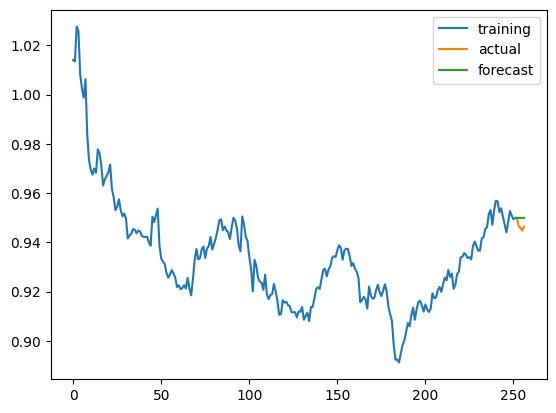

In [ ]:
#visualize the best case
model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
result = model.fit()

train_predictions = result.predict(start=1, end=train.shape[0])
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Modularization

In [ ]:
def fine_tune(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    #fine-tuning
    min_val_mse=1e9
    optimal_p=1
    optimal_d=1
    optimal_q=1
    for p in range(1,6):
        for d in range(1,3):
            for q in range(1,6):
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()
                train_predictions = result.predict(start=1, end=train.shape[0])
                val_predictions = result.get_forecast(len(val)).predicted_mean
                train_mse = mean_squared_error(train_predictions,train)
                val_mse = mean_squared_error(val_predictions, val)
                if (val_mse<min_val_mse):
                    min_val_mse=val_mse
                    optimal_p=p
                    optimal_q=q
                    optimal_d=d
    
    return optimal_p,optimal_d,optimal_q

In [ ]:
#find best hyper parameters for each dataset
best_parameters=[]
for i in range(5):
    best_parameters.append(fine_tune(df_train[i]))

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model

KeyboardInterrupt: 

In [ ]:
print(best_parameters)

[(4, 1, 3), (5, 1, 1), (1, 2, 3), (1, 2, 2), (1, 2, 2)]


In [ ]:
def get_best_model(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q=best_parameter
    model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


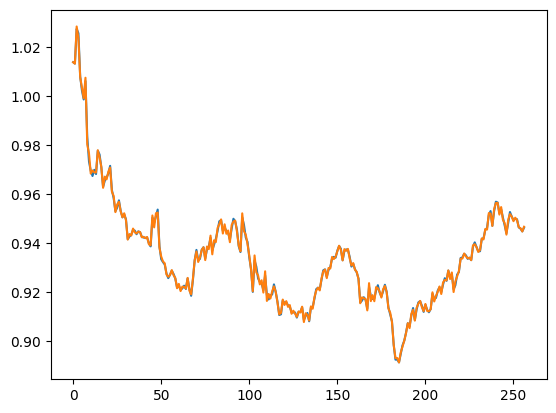

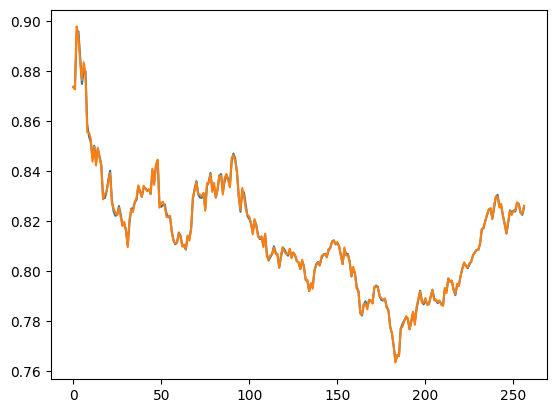

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


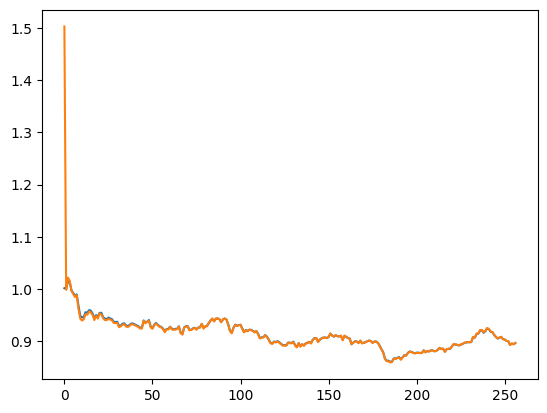

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


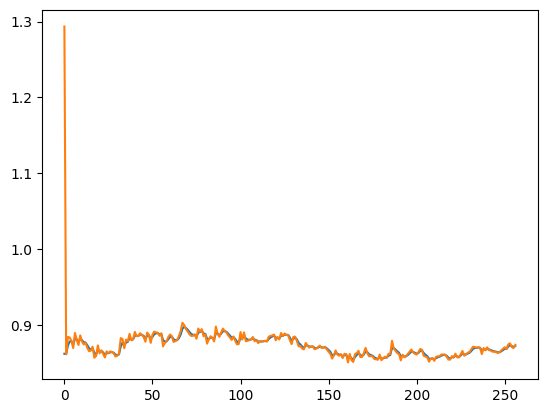

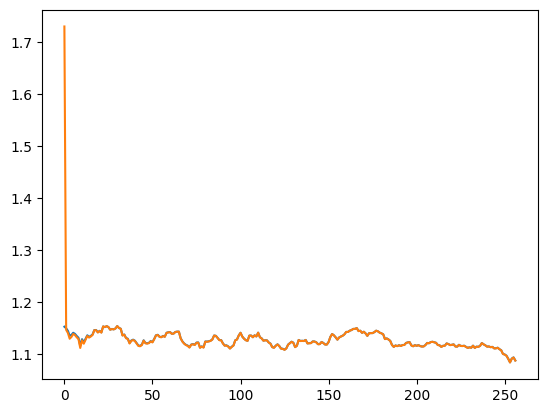

In [ ]:
models=[]
for i in range(5):
    models.append(get_best_model(df_train[i],best_parameters[i]))

## Compute Max Profit

In [ ]:
ARIMA_predictions=[]
for i in range(5):
    ARIMA_predictions.append(models[i].get_forecast(len(df_test[i])).predicted_mean)

In [ ]:
ARIMA_predictions=np.array(ARIMA_predictions)
ARIMA_predictions

array([[0.946713  , 0.94639371, 0.94652668, 0.9463809 , 0.9464848 ],
       [0.82598956, 0.8255828 , 0.82514794, 0.82525448, 0.82551547],
       [0.89705002, 0.89636305, 0.89680046, 0.8963253 , 0.8965908 ],
       [0.87402975, 0.87548947, 0.87694919, 0.87840892, 0.87986864],
       [1.0878928 , 1.0876322 , 1.08738427, 1.08712437, 1.08687577]])

In [ ]:
true_rate=[]
for i in range(5):
    true_rate.append(np.array(df_test[i]).squeeze())

In [ ]:
true_rate=np.array(true_rate)
true_rate

array([[0.95   , 0.9491 , 0.94801, 0.94629, 0.9501 ],
       [0.82847, 0.826  , 0.82695, 0.82508, 0.82663],
       [0.89993, 0.9034 , 0.90475, 0.91   , 0.9107 ],
       [0.87338, 0.87204, 0.87403, 0.87522, 0.87122],
       [1.09009, 1.09696, 1.09734, 1.10422, 1.1063 ]])

In [ ]:
def get_max_profit(rate):
    #We initially have 1000 dollars
    principal=1000
    # 5 days in total, we have 4 chances to make a profit
    for i in range(4):
        #Here, we initialize rate_increase to be 1. This is to prevent elements in rate_increase are all smaller than 1.
        rate_increase=np.array([1])
        #Here, we only need the first three predictions.
        for j in range(3):
            rate_increase=np.append(rate_increase,rate[j][i+1]/rate[j][-1])
        max_rate_increase=np.max(rate_increase)
        principal*=max_rate_increase
    return principal

In [ ]:
predict_profit=get_max_profit(ARIMA_predictions)
true_profit=get_max_profit(true_rate)
print(predict_profit,true_profit)

1000.3154168725081 1000.3871139445702


In [ ]:
#Compute MSE between the max profit computed via ARIMA and the actual profit 
profit_mse = (predict_profit-true_profit)**2
print("MSE between the max profit computed via ARIMA and the actual profit is:", profit_mse)

MSE between the max profit computed via ARIMA and the actual profit is: 0.005140470142274994
